# Examen Python data developer
# Deel 1
## Introductie
Voor dit examen is het belangrijk dat je volgende zaken zeker doet:
 - Maak een Vitual Environment aan & exporteer een `.yml` (of soortgelijke) file aan die je toevoegt aan je codebase.
 - Maak een github pagina aan met een bijhorende `.gitignore` en `readme.md`. Voeg een link naar de github repo toe aan je readme file.
 - Zorg dat je op het einde de tijd neemt om je code op te schonen zodat deze begrijpelijk is voor derden.
 - Wanneer je klaar bent, maak een `.zip` bestand van je volledige codebase aan en laad deze op in de leeromgeving.

In deze opgave bekijken we een gesimuleerde dataset over de geboortes in België van 2019. De data is te vinden in `.csv` bestanden die gelabeld zijn met de echte geboortedag van de personen in het bestand. Laat ons bijvoorbeeld even kijken naar de eerste 5 lijnen van het bestand `2019-1-1.csv`:

<table align="center">
  <tr>
    <th>gemeente</th>
    <th>naam</th>
    <th>geslacht</th>
    <th>verwachte datum</th>
  </tr>
  <tr>
    <td>Hooglede</td>
    <td>Elias</td>
    <td>Mannelijk</td>
    <td>01/14/2019</td>
  </tr>
  <tr>
    <td>Sint-Niklaas (Sint-Niklaas)</td>
    <td>Pauline</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Wijnegem</td>
    <td>Anita</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Grâce-Hollogne</td>
    <td>Jean-Paul</td>
    <td>Mannelijk</td>
    <td>01/13/2019</td>
  </tr>
  <tr>
    <td>Boussu</td>
    <td>François</td>
    <td>Mannelijk</td>
    <td>01/26/2019</td>
  </tr>
</table>


Hier hebben we de kolommen:
 - **gemeente**: De gemeente waar de persoon geboren is.
 - **naam**: De voornaam van de persoon.
 - **geslacht**: Het geslacht van de persoon (Mannelijk of Vrouwelijk).
 - **verwachte datum**: De verwachte geboortedatum van de persoon.

Dus hier hebben we dan bijvoorbeeld op de eerste lijn de mannelijke persoon Elias die geboren is in Hooglede waarvan men verwachtte dat hij zou geboren worden op `01/14/2019` (Amerikaans formaat) maar in feite geboren is op 1 januari 2019.

Doorheen deze opgave gaan we de data van dichterbij inspecteren! Je kan deze opgaves alternatief lezen in de bijgeleverde notebook `examen.ipynb` waar ook de (meeste) afbeeldingen & resultaten zichtbaar zijn.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Definieer data locaties
rootdir = os.path.join(os.getcwd(), '../')
datadir = os.path.join(rootdir, 'data')

#load custom style: 
sys.path.append(rootdir)           #add this parent to the system path
from utils import plotstyle
plotstyle.initialize_custom_style()

## Utilities

In [2]:
def to_percentage(number):
    return str(np.round(number * 100, 2)) + "%"

def compute_num_unique(df, n_births):
    return len(np.unique(df['naam'].sample(n_births)))

##my utils: 
def date_converter(dataframe): 
    """
        function that takes a dataframe and converts the columns to pd.datetime. 
    """
    dataframe['verwachte datum'] = pd.to_datetime(dataframe['verwachte datum'],format='%m/%d/%Y')
    dataframe['birthdate'] = pd.to_datetime(dataframe['birthdate'], format = '%Y-%m-%d')
    return dataframe


def find_extremes(dataframe, how_many=8):
    """
        takes a dataframe and integer as arguments: 

        function will filter out the top x (how_many == int type) records that are outliers based on the absolute distance to the mean 
        of a given dataframe for the second half of the year. 
    """
    mean_clean = dataframe.total_births.mean()
    dataframe['distance_to_mean_abs'] = np.abs(dataframe.total_births-mean_clean)
    #we filter on the second half of the year: (365/2)      then we sort them on the absolute diatnce to the mean   and we return a slice:
    return list(dataframe[dataframe.doy_birth > int(365/2)].sort_values('distance_to_mean_abs', ascending=False).iloc[0:how_many].doy_birth)



## Stap 1: data inlezen

Maak een lus over alle bestanden in de map `data/geboortes`, lees elk `.csv` bestand in en voeg deze samen tot 1 grote DataFrame. Merk op dat de datum verwerkt zit in de filename, voeg deze toe aan de kleine DataFrames voor je de dataframes samenvoegt met een `pd.concat(dfs)`.

Voeg een extra kolom toe met een `"dag van het jaar"` getal, dus 1 januari 2019 is `1`, 2 januari 2019 is `2`, enzovoort.

**Opmerking**: Er is ook data voor 29 februari 2019, terwijl dit geen schrikkeljaar is! Plaats deze geboortes in een afzonderlijke DataFrame `df_wrong`. Zet in `df_wrong` een extra kolom met een referentie naar waarom deze data foutief is.

In [3]:
datalist = []
for file in os.listdir(datadir):
    datafile = pd.read_csv(os.path.join(datadir, file))
    date_of_birth = file.replace('.csv', '')
    datafile['birthdate'] = date_of_birth.strip()
    if file.startswith('2019-2-29'):
        df_wrong = datafile.copy()
        df_wrong['reason'] = 'date does not exist'
        continue

    datalist.append(datafile)


In [4]:
#merge everything into a single dataframe: 
data = pd.concat(datalist, ignore_index=True)

In [5]:
data.isnull().sum()     #NO NULLS, good to go

gemeente           0
naam               0
geslacht           0
verwachte datum    0
birthdate          0
dtype: int64

In [6]:
data.describe()

,gemeente,naam,geslacht,verwachte datum,birthdate
count,116850,116850,116850,116850,116850
unique,579,5255,2,427,365
top,Antwerpen,Maria,Mannelijk,07/06/2019,2019-7-1
freq,6051,1627,58932,399,923


In [7]:
data.sample(20)

,gemeente,naam,geslacht,verwachte datum,birthdate
98847,Wezembeek-Oppem,Jack,Mannelijk,08/31/2019,2019-8-13
39057,Nijvel,Maxime,Mannelijk,02/22/2019,2019-2-12
19713,Nijlen,Nick,Mannelijk,11/05/2019,2019-11-1
17691,Anderlecht,Zayd,Mannelijk,11/02/2019,2019-10-31
17109,Bièvre,Philippe,Mannelijk,10/14/2019,2019-10-3
87687,Pelt,Peter,Mannelijk,07/26/2019,2019-7-10
58210,Ieper,Stan,Mannelijk,05/05/2019,2019-4-12
102279,Eeklo,Conny,Vrouwelijk,09/04/2019,2019-8-23
51215,Charleroi,Olivier,Mannelijk,03/30/2019,2019-3-20
24558,Ottignies-Louvain-la-Neuve,Françoise,Vrouwelijk,12/06/2019,2019-11-24


In [8]:

#make life easier and let's change the two date fields into datetime objects:
#data['verwachte datum'] = pd.to_datetime(data['verwachte datum'],format='%m/%d/%Y')
#data['birthdate'] = pd.to_datetime(data['birthdate'], format = '%Y-%m-%d')

data = date_converter(data)

In [9]:
data_extended = data.copy()
#add the Day Of Year ==> DOY_ prefix used
data_extended['doy_birth'] = data_extended.birthdate.dt.dayofyear
data_extended['doy_expected'] = data_extended['verwachte datum'].dt.dayofyear
data_extended['weekday'] = data_extended.birthdate.dt.strftime('%A')

In [10]:
data_extended

,gemeente,naam,geslacht,verwachte datum,birthdate,doy_birth,doy_expected,weekday
0,Hooglede,Elias,Mannelijk,2019-01-14,2019-01-01,1,14,Tuesday
1,Sint-Niklaas (Sint-Niklaas),Pauline,Vrouwelijk,2019-01-05,2019-01-01,1,5,Tuesday
2,Wijnegem,Anita,Vrouwelijk,2019-01-05,2019-01-01,1,5,Tuesday
3,Grâce-Hollogne,Jean-Paul,Mannelijk,2019-01-13,2019-01-01,1,13,Tuesday
4,Boussu,François,Mannelijk,2019-01-26,2019-01-01,1,26,Tuesday
...,...,...,...,...,...,...,...,...
116845,Lede,Lobke,Vrouwelijk,2019-09-12,2019-09-09,252,255,Monday
116846,Westerlo,Willem,Mannelijk,2019-09-04,2019-09-09,252,247,Monday
116847,Brugge,Diane,Vrouwelijk,2019-09-20,2019-09-09,252,263,Monday
116848,Lendelede,Marie-Rose,Vrouwelijk,2019-10-28,2019-09-09,252,301,Monday


## Stap 2: Dagelijks aantal geboortes bekijken
#### Vraag 1: Maak een plot van het aantal geboortes per dag van het jaar. 

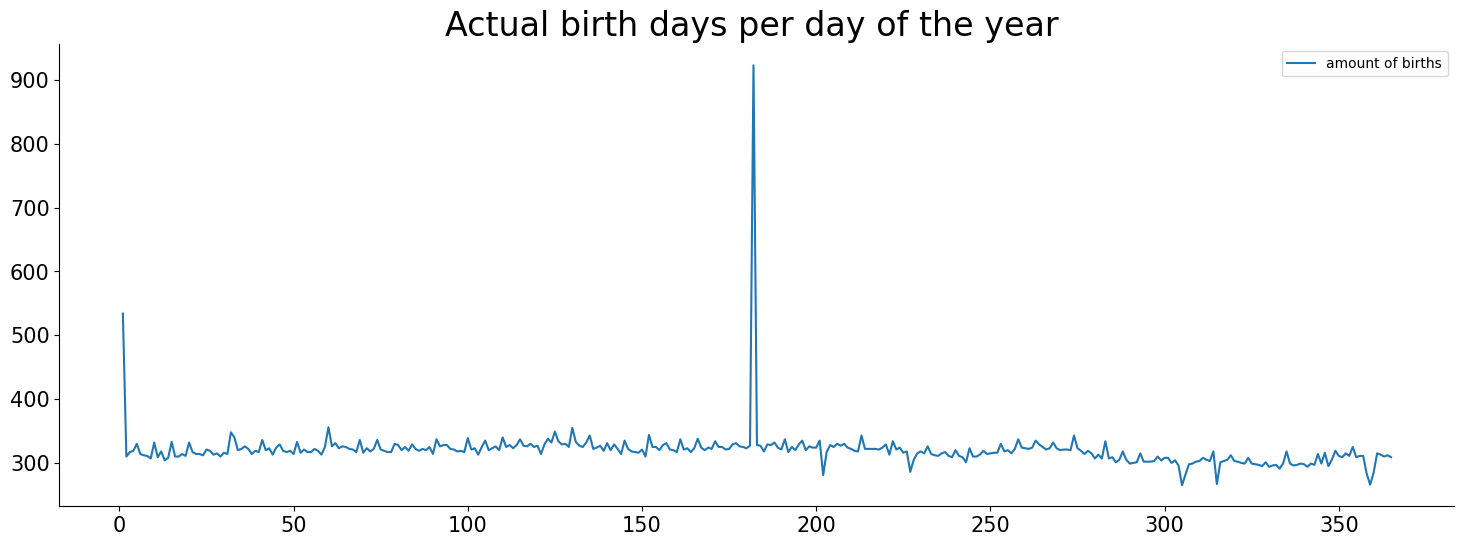

In [11]:
births_per_day = data_extended.groupby('doy_birth').size().reset_index()
births_per_day
#data_extended.query('doy_birth == 361') #random checks okay: good to go
fig, ax = plt.subplots() 
ax.plot(births_per_day.doy_birth, births_per_day[0], label='amount of births')
plt.title('Actual birth days per day of the year ')
plt.legend()
plt.show()

#### Vraag 2: Outliers vinden & behandelen

We klassificeren een datum als een outlier als het aantal geboortes meer dan `50%` afwijkt van de gemiddelde waarde overheen de volledige dataset. Zoek alle outliers in de dataset.

In [12]:
#mean actuals: 
mean_actuals = births_per_day[0].mean()
#define the boundaries; 
mean_low = mean_actuals/2   #lower boundary = half of the mean
mean_high = 1.5*mean_actuals    #upper boundary mean + half of the mean
keep_mask = births_per_day[0].between(mean_low, mean_high)
doy_birth_records_to_remove = list(births_per_day[~keep_mask].doy_birth)


doy_birth_records_to_remove       #these are the DOY_birth values we have to remove: 

[1, 182]

Ik zal je vertellen; de outliers op 1 januari en 1 juli komen doordat alle geboortes waarvoor de datum niet correct genoteerd is, de datum 1 januari (voor de eerste helft van het jaar) en op 1 juli (voor de tweede helft van het jaar) geplaatst worden. Om dit op te lossen, halen we in de grote geboortes DataFrame (met 1 lijn per geboorte) deze twee datums er volledig uit. Dus we gaan **alle** geboortes van 1 januari en 1 juli verwijderen uit deze dataframe en toevoegen aan de `df_wrong` dataframe met als reden `2019-01-01` en `2019-07-01`.

In [13]:
temp_transfer = data_extended[data_extended['doy_birth'].isin(doy_birth_records_to_remove)].copy()
# we will convert the birthdate back to the string as it exists in df_wrong. The reason for this is 
#that we want to retain column-uniformatie. 29/2/2019 cannot be a datetime, so our next best option
#is to keep it as a string. This way, we don't  lose data.
#We won't bother dropping the extra columns. Pandas will autofill it with NULL for us anyway. We know
#we caused it here, so not a big deal. 


temp_transfer['birthdate'] = temp_transfer['birthdate'].dt.strftime('%Y-%m-%d')

In [14]:
temp_transfer.birthdate.dtype   #okay it's an object now. 
temp_transfer['reason'] = temp_transfer.birthdate
print(df_wrong.shape)           # if we do the concat good we should be 73+1457 rows in wrong.
print(temp_transfer.shape)
#do not reassign to df_wrong, otherwise a second iter of this cell will crete duplicate
df_wrong_extended = pd.concat([df_wrong, temp_transfer], ignore_index=True)


(73, 6)
(1457, 9)


In [15]:
#now we want to remove these days from data_extended: 
mask = data_extended['doy_birth'].isin(doy_birth_records_to_remove)
data_extended_filtered = data_extended[~mask]
#check: did we do good: 
data_extended_filtered.shape[0]+temp_transfer.shape[0] == data_extended.shape[0]
#done: 
#   data that had to be removed from data_extended is moved into df_wrong_extended. 
#   df_wrong has systematic strings representing (wrong) dates (unity of type conserved)


True

Maak dezelfde plot nu opnieuw met het aantal geboortes per dag.

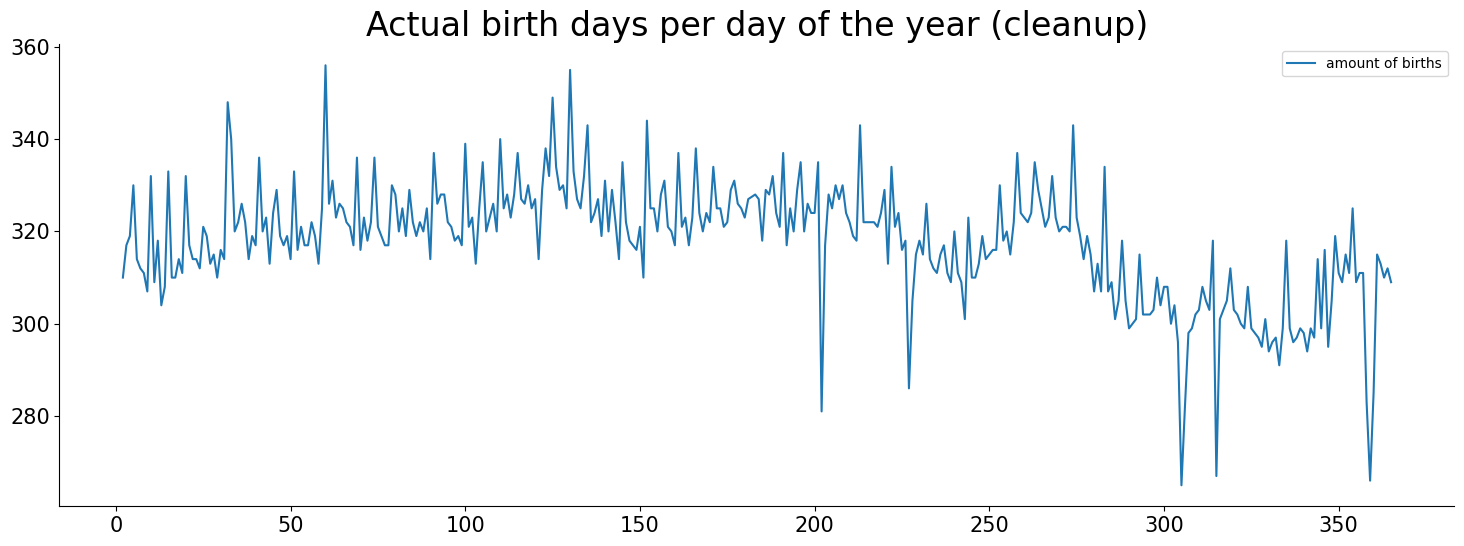

In [16]:
births_per_day_clean = data_extended_filtered.groupby('doy_birth').size().reset_index()
births_per_day_clean.columns = ['doy_birth', 'total_births']
#data_extended.query('doy_birth == 361') #random checks okay: good to go
fig, ax = plt.subplots() 
ax.plot(births_per_day_clean.doy_birth, births_per_day_clean.total_births, label='amount of births')
plt.title('Actual birth days per day of the year (cleanup)')
plt.legend()
plt.show()

 We zien dat er nog steeds redelijk wat uitschieters zijn, kan je code schrijven om de 5 extreme uitschieters in de 2e helft van het jaar identificeren (in totaal 8 datums)?

In [17]:
#based on the example graph provided you'd just query on everything that's lower than 290?
#I'm assuming we can't do that and need to look for extreme values. 
#what I'll do is calculate the mean, and then for each day the distance to that mean. The days with the highest distance are the outliers: 
#mean_clean = births_per_day_clean.doy_birth

#TODO DISCUSS WITH TIM: Tim is calculating extreme values based on low outliers, in fact, when you look at the absolute distance, we have high outliers too. Don't we need these.

extreme_doys = find_extremes(births_per_day_clean, 8)
print('These are the extreme days:')
combined = (births_per_day_clean[births_per_day_clean.doy_birth.isin(extreme_doys)]
            .merge(data_extended[['doy_birth','birthdate']], on='doy_birth', how='left')
            .drop_duplicates()
            )
combined

These are the extreme days:


,doy_birth,total_births,distance_to_mean_abs,birthdate
0,202,281,36.887052,2019-07-21
281,227,286,31.887052,2019-08-15
567,305,265,52.887052,2019-11-01
832,306,282,35.887052,2019-11-02
1114,315,267,50.887052,2019-11-11
1381,358,283,34.887052,2019-12-24
1664,359,266,51.887052,2019-12-25
1930,360,285,32.887052,2019-12-26


### Bonusvraag: wekelijkse verbanden

We zien vele pieken en dalen in de evolutie van het aantal geboortes. We willen deze grafiek graag iets "gladder" maken. Kan je hiervoor eens een visualizatie maken van het **gemiddeld** aantal geboortes per week (dit voor elke week, dus maandag-maandag, dinsdag-dinsdag, woensdag-woensdag, ...).

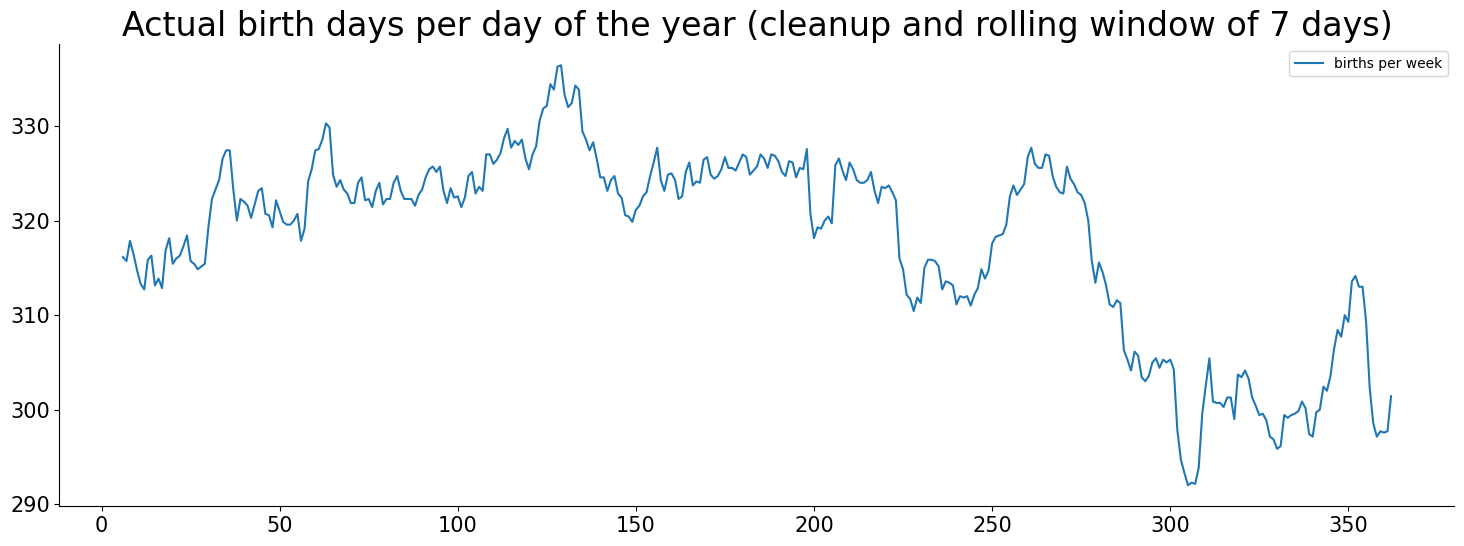

In [18]:
births_per_day_clean['moving_avg'] = births_per_day_clean['total_births'].rolling(window=7).mean()
fig, ax = plt.subplots() 
ax.plot(births_per_day_clean.index, births_per_day_clean['moving_avg'], label='births per week')
plt.title('Actual birth days per day of the year (cleanup and rolling window of 7 days)')
plt.legend()
plt.show()

Dat ziet er al een stuk mooier uit!  We zien ook een aantal duidelijk dips & pieken verschijnen die we eerder niet zagen. We kunnen nu ook even kijken naar het gemiddeld aantal geboortes per dag van de week! Misschien worden er wel gewoon veel minder mensen geboren op zondag dan een andere dag?

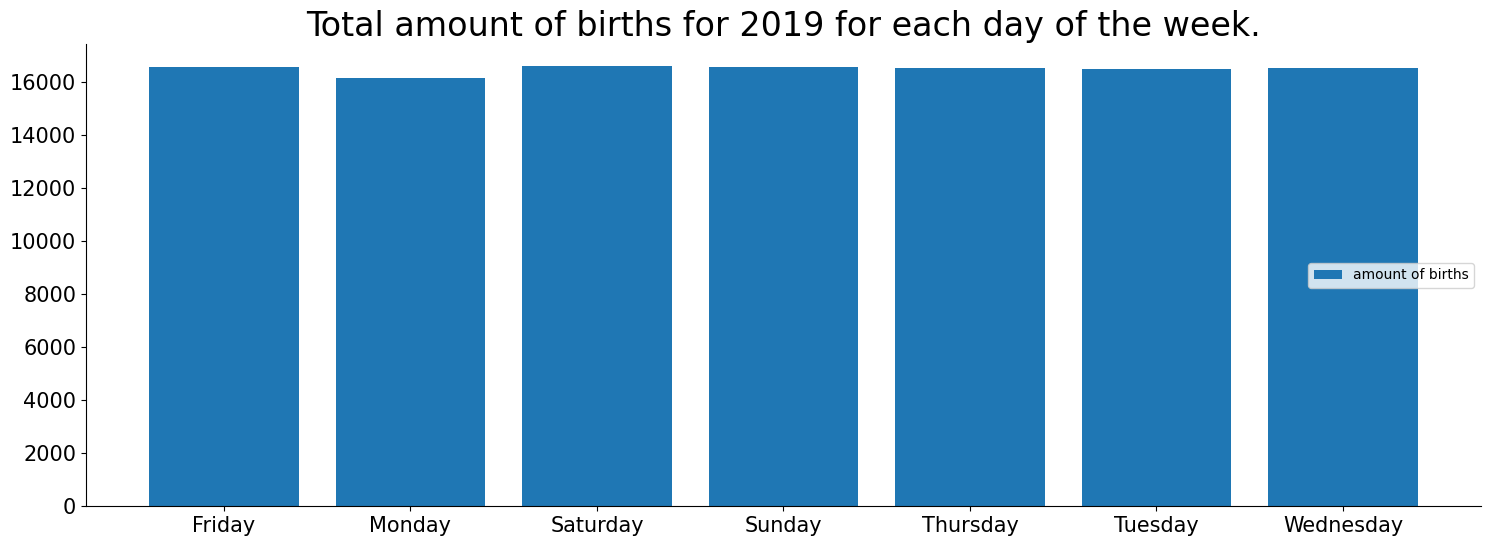

In [19]:
#we are using the data without the wrong date 29/2 and our outliers at the start and the middle of the year: 
weekcounts = data_extended_filtered.groupby('weekday').size().reset_index()
fig, ax = plt.subplots() 
ax.bar(weekcounts.weekday, weekcounts[0], label='amount of births')
plt.title('Total amount of births for 2019 for each day of the week.')
plt.legend(loc='center right')
plt.show()

# Exam part two:

### Onderzoek 1: Unisex namen
#### Een aantal statistieken
Sommige namen zijn unisex, dat wil zeggen dat zij hetzelfde zijn voor mannen en vrouwen. Beantwoord volgende 3 vragen over unisex namen in onze dataset:
 - Hoeveel unisex namen zijn er?
 - Wat is de meest voorkomende unisex naam; hiervoor zoek ik 3 namen (en getallen):
    - De meest populaire unisex naam bij mannen.
    - De meest populaire unisex naam bij vrouwen.
    - De meest popuaire unisex naam.

**Tip:** Neem hiervoor terug de volledige dataset in acht (dus met de foutief geklasseerde namen).
==> neem ALLE namen mee ook die van 29/2/2019

In [46]:
#merge them together to get all names, we only need the rows where reason == data does not exist. 
# because: data does not have any other filter applied to it. 
# so concat: data_extended and df_wrong 
names_data = pd.concat([data_extended[['geslacht', 'naam']], df_wrong.query('reason == "date does not exist"')[['geslacht','naam']]], axis=0)

In [47]:
#to find unisex names: split the dataset in two by sex and use intersection to find common elements. Use MASKING
male_names = names_data.geslacht == 'Mannelijk'
female_names = names_data.geslacht == 'Vrouwelijk'

In [48]:
unisex_names = set(names_data[male_names]['naam']).intersection(set(names_data[female_names]['naam']))
print(f"There are {len(unisex_names)} unisex names in this dataset")


There are 75 unisex names in this dataset


In [49]:
#mask out the males/females that have unisex names: 
males_with_unisex_names = names_data[male_names]['naam'].isin(unisex_names)
females_with_unisex_names = names_data[female_names]['naam'].isin(unisex_names)

In [55]:
#now apply that mask to subslice and get them out, then apply a groupby
unisex_namedata = names_data[names_data.naam.isin(unisex_names)]

In [160]:
most_pop_men_unisex_names = unisex_namedata.query('geslacht == "Mannelijk"').groupby('naam').size().sort_values(ascending=False).reset_index()
most_pop_fem_unisex_names = unisex_namedata.query('geslacht == "Vrouwelijk"').groupby('naam').size().sort_values(ascending=False).reset_index()
#we can solve this by combining: most_pop_men_unisex_names with most_pop_fem_unisex_names. Merging will happen on the matching 'naam' column,
# before that we need to update the column nams so that we have a column 'male_count' and a column 'female_count'
#once we have that, we can calculate the ratio and total in a bigger dataframe
most_pop_men_unisex_names = most_pop_men_unisex_names.rename(columns={0: 'male_count'})
most_pop_fem_unisex_names = most_pop_fem_unisex_names.rename(columns={0: 'female_count'})
unisex_names_sex_frequencies = pd.merge(most_pop_men_unisex_names, most_pop_fem_unisex_names, on='naam')
unisex_names_sex_frequencies['total'] = unisex_names_sex_frequencies['male_count'] + unisex_names_sex_frequencies['female_count']
unisex_names_sex_frequencies['male_ratio'] = unisex_names_sex_frequencies['male_count'] / unisex_names_sex_frequencies['total']
unisex_names_sex_frequencies['female_ratio'] = unisex_names_sex_frequencies['female_count'] / unisex_names_sex_frequencies['total']
#from the assignment:   male_true is a true unisex name if x(males)                     <= y(females) *1.5 and vice versa
unisex_names_sex_frequencies['male_true'] = unisex_names_sex_frequencies['male_count'] <= unisex_names_sex_frequencies['female_count'] * 1.5
unisex_names_sex_frequencies['female_true'] = unisex_names_sex_frequencies['female_count'] <= unisex_names_sex_frequencies['male_count'] * 1.5
#add an extra column to check if both are true: 
unisex_names_sex_frequencies['both_true'] = (unisex_names_sex_frequencies['male_true'] & unisex_names_sex_frequencies['female_true'])

def extract_top_name(df, col): 
    """
        extracts the name with the highest frequency from a variabel column (col)
        df = A pandas dataframe
        col = the name of the column with the frequency counts in.
    """
    return df.sort_values(by=col, ascending=False).head(1).reset_index()['naam'][0]
#most_pop_overall_unisex_names = unisex_namedata.groupby('naam').size().sort_values(ascending=False).reset_index()

In [147]:
print(f"Populairste unisex naam bij de mannen: {extract_top_name(unisex_names_sex_frequencies, 'male_count')}")
print(f"Populairste unisex naam bij de vrouwen: {extract_top_name(unisex_names_sex_frequencies, 'female_count')}")
print(f"Populairse unisex naam in het algemeen: {extract_top_name(unisex_names_sex_frequencies, 'total')}")

Populairste unisex naam bij de mannen: Maxime
Populairste unisex naam bij de vrouwen: Dominique
Populairse unisex naam in het algemeen: Dominique


We zien dat er een vrij groot aantal namen veel meer voorkomen bij mannen dan vrouwen (en omgekeerd). Dit vinden we eigenlijk geen "echte" unisex namen. We noemen een naam "echt unisex" als de naam niet meer dan 50% meer voorkomt bij 1 van de 2 geslachten. Dus als er `x` mannen en `y` vrouwen zijn genaamd Chris, dan noemen we Chris "echt unisex" als `x <= 1.5 * y` en `y <= x * 1.5`. Filter je unisex dataframe tot een `df_real_unisex` waarbij je enkel de "echte" unisex namen weerhoudt. 
- Beantwoord nu bovenstaande 3 vragen opnieuw voor deze dataset. Hierbij werk je best met een functie zodat je geen code moet herhalen!
- Zijn de echte unisex namen populairder bij mannen of vrouwen, of is de populariteit hetzelfde? Deze vraag kan je beantwoorden door te kijken naar het percentage mannen/vrouwen met een echte unisex naam.

In [378]:
print(f"Populairste echte unisex naam bij de mannen: {extract_top_name(unisex_names_sex_frequencies[unisex_names_sex_frequencies.male_true == True], 'male_count')}")
print(f"Populairste echte unisex naam bij de vrouwen: {extract_top_name(unisex_names_sex_frequencies[unisex_names_sex_frequencies.female_true == True], 'female_count')}")
print(f"Populairse echte unisex naam in het algemeen: {extract_top_name(unisex_names_sex_frequencies[unisex_names_sex_frequencies.both_true == True], 'total')}")

Populairste echte unisex naam bij de mannen: Dominique
Populairste echte unisex naam bij de vrouwen: Dominique
Populairse echte unisex naam in het algemeen: Dominique


In [246]:
# I consider df_real_unisex to only have names in it that are considered a 'real_unisex' name for both males and females: 
df_real_unisex = unisex_names_sex_frequencies[unisex_names_sex_frequencies.both_true == True]
real_unisex_names = set(df_real_unisex['naam'])
#we can now use the set real_unisex_names to query the original df using isin() to get an estimate of the percentage.

In [338]:
male_real_unisex_name_ratio = pd.DataFrame(names_data[names_data.naam.isin(real_unisex_names)].geslacht =='Mannelijk').sum().reset_index()[0]/names_data.shape[0]
female_real_unisex_name_ratio = pd.DataFrame(names_data[names_data.naam.isin(real_unisex_names)].geslacht =='Vrouwelijk').sum().reset_index()[0]/names_data.shape[0]

In [339]:
print(f"Percentage mannen met ECHTE unisex naam: {male_real_unisex_name_ratio[0]*100}%")
print(f"Percentage vrouwen met ECHTE unisex naam: {female_real_unisex_name_ratio[0]*100}%")



Percentage mannen met ECHTE unisex naam: 0.19328960084842162%
Percentage vrouwen met ECHTE unisex naam: 0.24631595152365232%


#### Visualizatie

Maak een visualizatie die alle echte unisex namen toont en de relatieve voorkomens bij mannen en vrouwen.

In [351]:
#for the visualisation we can use the ratio, these two together will be close enough to 1; this 
# will act like a horizontal stacked bar chart. We mask from our data using the real_unisex_names set.
visualization_prepare = unisex_names_sex_frequencies[unisex_names_sex_frequencies.naam.isin(real_unisex_names)].sort_values('male_ratio')
#here too I get deviating numbers. 
# visualization_prepare.male_count.sum()/names_data.shape[0]

0.001932896008484216

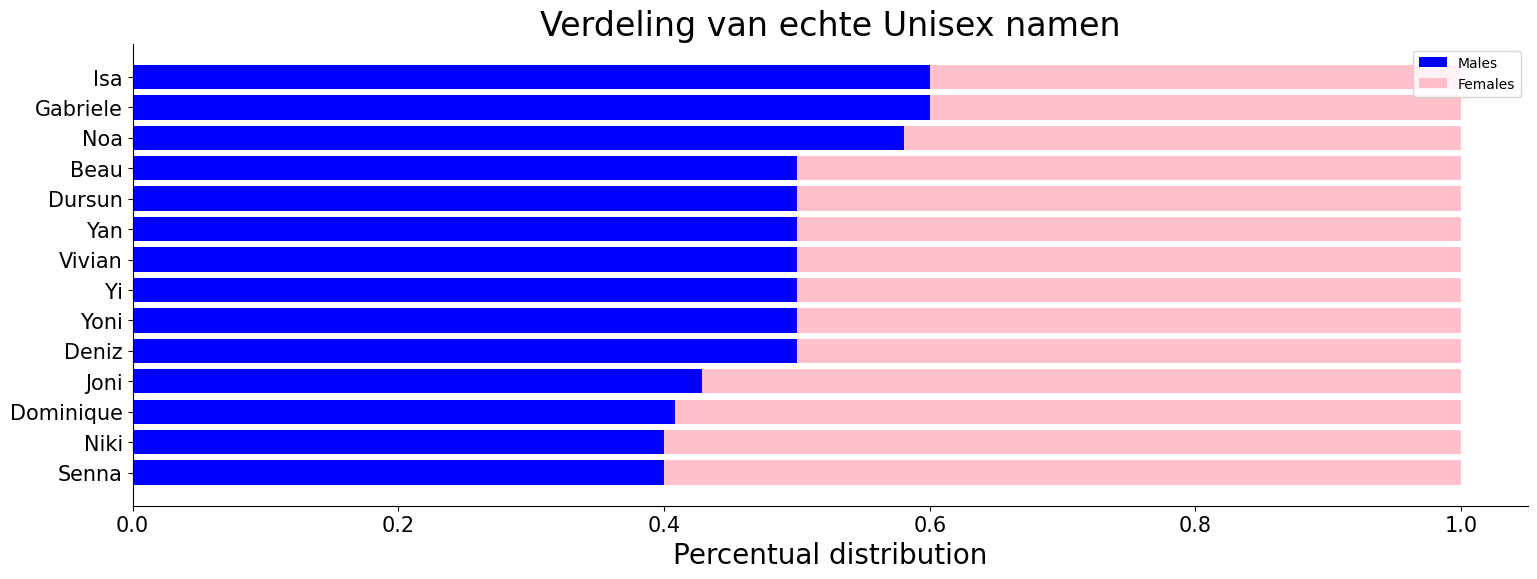

In [352]:
names = visualization_prepare.naam
male_values = visualization_prepare.male_ratio
female_values = visualization_prepare.female_ratio

# Number of categories
n = len(names)

# Create a bar chart
fig, ax = plt.subplots()

# Create the first set of bars
ax.barh(names, male_values, color='blue', label='Males')

# Create the second set of bars
ax.barh(names, female_values, left=male_values, color='pink', label='Females')

# Add labels and title
ax.set_xlabel('Percentual distribution')
ax.set_title('Verdeling van echte Unisex namen')

# Add legend
ax.legend()

# Show the plot
plt.show()

### Onderzoek 2: de accuraatheid van de geschatte bevallingsdatum
#### Evolutie vergelijken

Maak een afbeelding van het totaal aantal geboortes per dag en het totaal aantal verwachte geboortes.

**Bonusvraag**: Gewoon om over na te denken: waarom zien de uiteindes van je plot er wat gek uit? Schrijf het antwoord neer in een strategisch geplaatste markdown cel.

In [353]:
data_extended_filtered_delta = data_extended_filtered.copy()
data_extended_filtered_delta['birthdelta'] = data_extended_filtered_delta['birthdate'] - data_extended_filtered_delta['verwachte datum']
data_extended_filtered_delta['birthdelta_int'] = data_extended_filtered_delta['birthdelta'].dt.days

In [354]:
#for this we need the cleaned up dataframe with the wrong data and conventional dates removed. We can reuse 'data_extended_filtered' safely
#the easiest is two groupbys, just to be safe we assume days where we have no expectations or no actuals, we fill them up later with 0 if needed
day_of_year_exp = []
expected = []
#because of that we have a duplicate list here; if day_of_year_exp == day_of_year_act then we can skip the need to check.
day_of_year_act = []
actuals = []

for day, df in data_extended_filtered.groupby('doy_expected'): 
    day_of_year_exp.append(day)
    expected.append(df.shape[0])
for day, df in data_extended_filtered.groupby('doy_birth'): 
    day_of_year_act.append(day)
    actuals.append(df.shape[0])

expectations = pd.DataFrame({
    'DOY': day_of_year_exp,
    'expected': expected
})
observations = pd.DataFrame({
    'DOY': day_of_year_act,
    'actuals': actuals
})

In [355]:
birth_frequencies = pd.merge(expectations, observations, on='DOY')

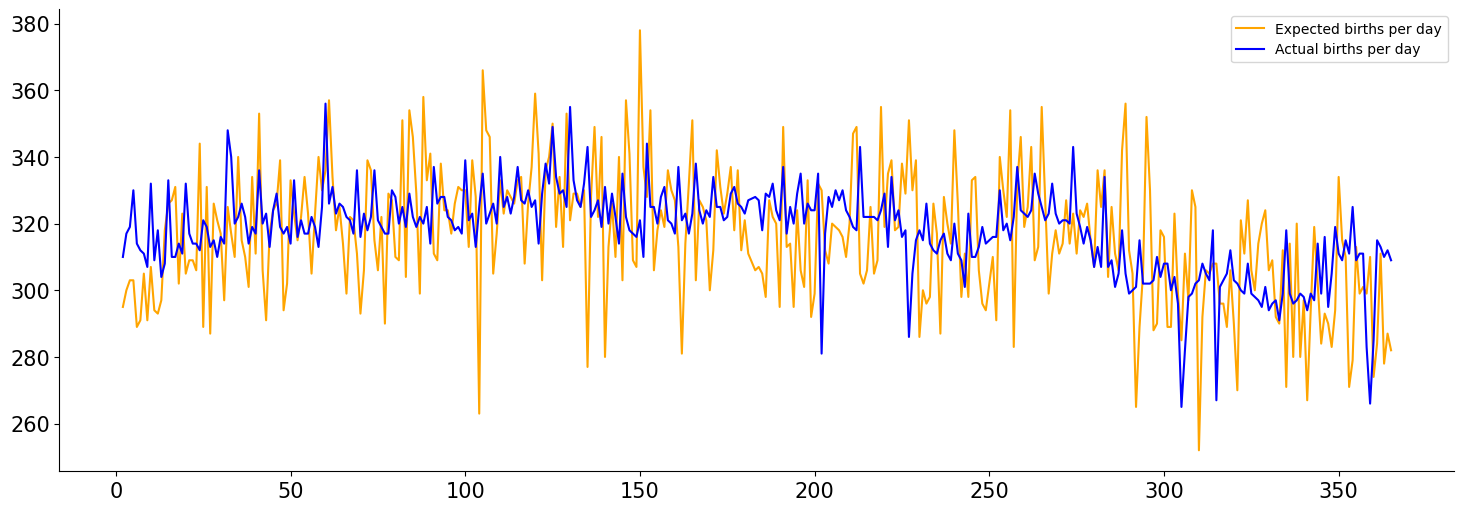

In [269]:
fig, ax = plt.subplots() 
ax.plot(birth_frequencies.DOY, birth_frequencies['expected'], label='Expected births per day', color = 'orange')
ax.plot(birth_frequencies.DOY, birth_frequencies['actuals'], label='Actual births per day', color = 'blue')
plt.legend()
plt.show()

#### Verbanden bekijken
Maak een histogram van het aantal dagen dat babies te vroeg geboren werden in 2019 en een scatterplot die het verband toont tussen de verwachte en effectieve geboortedatum.

In [284]:
data_extended_filtered_delta

,gemeente,naam,geslacht,verwachte datum,birthdate,doy_birth,doy_expected,weekday,birthdelta,birthdelta_int
534,Merksplas,Liliane,Vrouwelijk,2019-01-04,2019-01-10,10,4,Thursday,6 days,6
535,Bornem,Jeroen,Mannelijk,2019-01-10,2019-01-10,10,10,Thursday,0 days,0
536,Houthalen-Helchteren,Fatima,Vrouwelijk,2019-01-21,2019-01-10,10,21,Thursday,-11 days,-11
537,Lievegem,Hilaire,Mannelijk,2019-01-15,2019-01-10,10,15,Thursday,-5 days,-5
538,Spiere-Helkijn,Christian,Mannelijk,2019-01-16,2019-01-10,10,16,Thursday,-6 days,-6
...,...,...,...,...,...,...,...,...,...,...
116845,Lede,Lobke,Vrouwelijk,2019-09-12,2019-09-09,252,255,Monday,-3 days,-3
116846,Westerlo,Willem,Mannelijk,2019-09-04,2019-09-09,252,247,Monday,5 days,5
116847,Brugge,Diane,Vrouwelijk,2019-09-20,2019-09-09,252,263,Monday,-11 days,-11
116848,Lendelede,Marie-Rose,Vrouwelijk,2019-10-28,2019-09-09,252,301,Monday,-49 days,-49


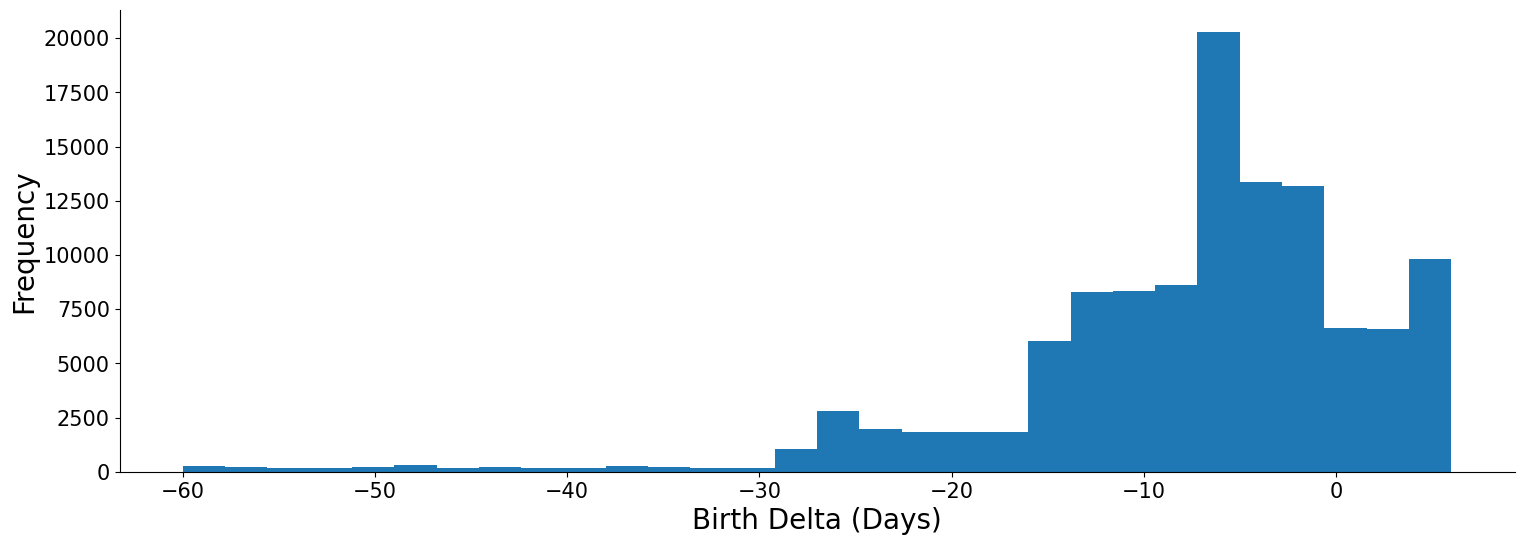

In [291]:
plt.hist(x=data_extended_filtered_delta.birthdelta_int, bins=30)
plt.xlabel('Birth Delta (Days)')
plt.ylabel('Frequency')
plt.show()

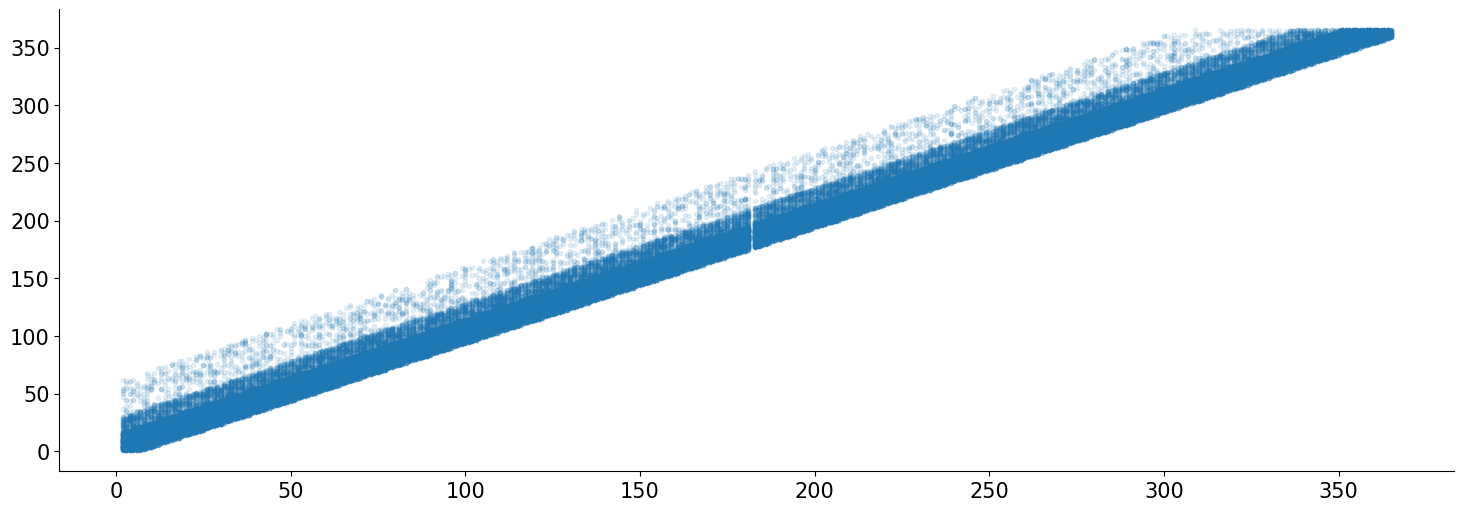

In [377]:
cutoffs = 100
plt.scatter(
    x = data_extended_filtered_delta[
        (data_extended_filtered_delta['doy_birth'] - data_extended_filtered_delta['doy_expected'] < cutoffs) & 
        (data_extended_filtered_delta['doy_birth'] - data_extended_filtered_delta['doy_expected'] > -cutoffs)
        ].doy_birth,
    y = data_extended_filtered_delta[
        (data_extended_filtered_delta['doy_birth'] - data_extended_filtered_delta['doy_expected'] < cutoffs) & 
        (data_extended_filtered_delta['doy_birth'] - data_extended_filtered_delta['doy_expected'] > -cutoffs)
        ].doy_expected,
    marker='.',
    alpha = 0.1
)

### Onderzoek 3: Aantal namen versus aantal babies
Naarmate dat er meer babies geboren worden, gaan deze ook meer verschillende namen krijgen. Zolang er weinig babies geboren worden lijkt het logisch dat dit verband min of meer lineair is, maar naarmate dat er meer en meer babies geboren worden lijkt het niet meer logisch dat dit verband lineair blijft. We verwachten bijvoorbeeld niet dat het aantal unieke namen gegeven aan 2 miljoen babies het dubbel is van het aantal unieke namen gegeven aan 1 miljoen babies. Kan je op basis van deze dataset het verband tussen het aantal unieke namen in functie van het aantal babies eens onderzoeken? Hiervoor krijg je geen voorstel tot visualizatie maar moet je zelf mij proberen te overtuigen van je antwoord.

In [332]:
#this is something you'd do with bootstrapping: 
bag_of_names = pd.Series(names_data.naam)
sim_len = 10**6
populationsizes = []
unique_names = []
for i in range(1, sim_len, 500):
    populationsizes.append(i)
    sampled_df = names_data.sample(n=i, replace=True)
    uq = sampled_df.naam.nunique()
    unique_names.append(uq)

In [333]:
pop_uq_name_corr = pd.DataFrame({
    'populationsize': populationsizes,
    'unique_names': unique_names
})

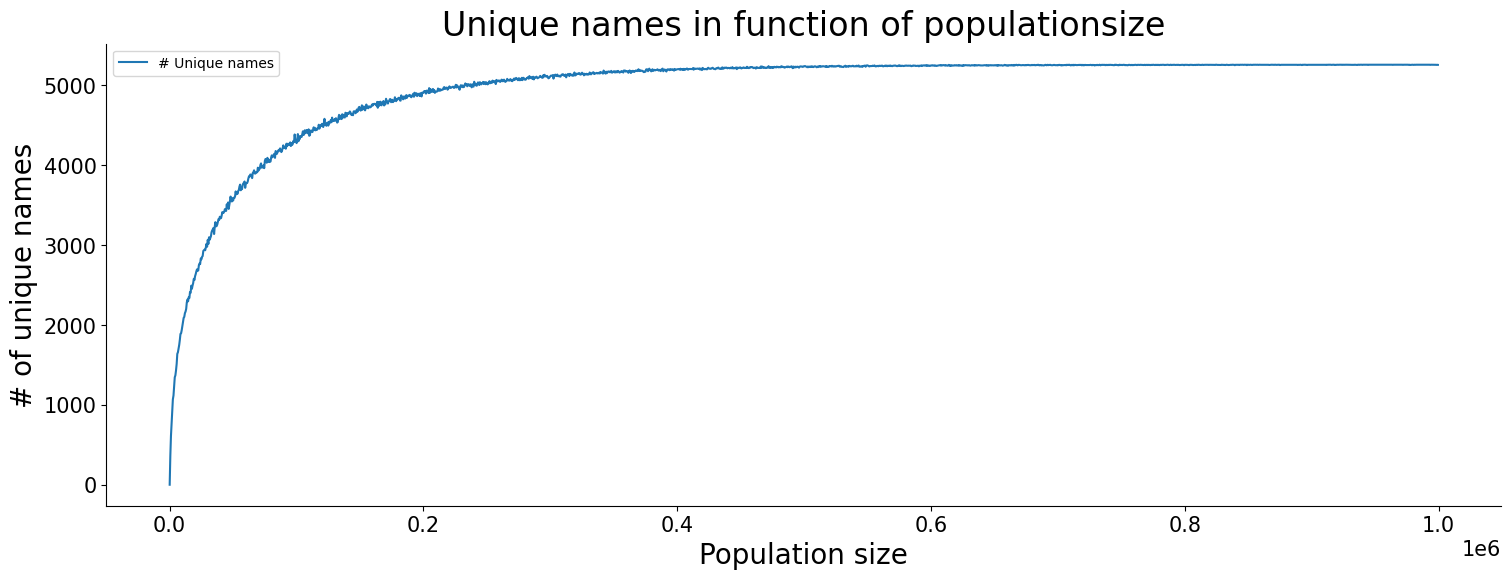

In [372]:
fig, ax = plt.subplots() 
ax.plot(pop_uq_name_corr.populationsize, pop_uq_name_corr.unique_names, label='# Unique names')
plt.title('Unique names in function of populationsize')
plt.legend()
plt.xlabel('Population size')
plt.ylabel('# of unique names')
plt.show()

An attempt to convince you: as you can see by the blue line we see a declining increase in the amount of unique names as our population size increses, we can see that once we hit a population size of about 400.000 names, there's no real increase in unique names any more. 